## Создание Датасета

In [14]:
import time
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import  matplotlib.image as img
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from plot_cm import plot_confusion_matrix

plt.style.use('seaborn')

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import matplotlib, sklearn
my_inst = [tf, np, matplotlib, sklearn]
my_req=[]
with open('requirements.txt', 'w') as f:
  for i in my_inst:
    req = '{}=={}'.format(i.__name__, i.__version__)
    print(req)
    f.write(req)
  


tensorflow==1.14.0
numpy==1.16.4
matplotlib==3.0.3
sklearn==0.21.3


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Функция, которая на вход принимает путь к исходным файлам и возвращает датасет с метками


In [0]:
def get_dataset(path):
  #Получим названия файлов
  file_names  = os.listdir(path)
  label_names = [name for name in file_names if '.txt' in name]
  image_names = [name for name in file_names if ('.jpg' in name) & ('_rect' not in name)]
  #Храним файлы в словаре, в качестве ключей берем названия файлов без расширения (Для удобства переобразуем в int)
  label_info_dic = {}
  for name in label_names:  
    labels_arr = loadtxt(path+name, comments="#", delimiter=" ", unpack=False)
    label_info_dic[int(name.split('.')[0])]=labels_arr.astype('int')

  imgs_dic={}
  for name in image_names:
    im = cv2.imread(path+name,0)  
    imgs_dic[int(name.split('.')[0])] = im
  #Создание датасета  
  image_datas = []
  labels = []
  for key in imgs_dic:
    for line in label_info_dic[key]:
      x, y, w, h, label = line    
      part_img = imgs_dic[key][y:y+h, x:x+w]
      try:
        #уменьшим до размерномть до 28x28
        part_img = cv2.resize(part_img, (28,28))
        #Нормализация пикселов
        part_img = part_img/part_img.max()
        image_datas.append(part_img)
        labels.append(label)
      except:
        print(key,"не удалось")
  image_datas = np.array(image_datas)
  labels = np.array(labels)
  return(image_datas, labels)

In [24]:
%%time
path = 'drive/My Drive/1/'
image_datas, labels = get_dataset(path)

242 не удалось
CPU times: user 2.77 s, sys: 376 ms, total: 3.15 s
Wall time: 3.85 s


In [25]:
print('Размерность полученной выборки:',image_datas.shape)
print('Кол-во меток:',len(labels))

Размерность полученной выборки: (1839, 28, 28)
Кол-во меток: 1839


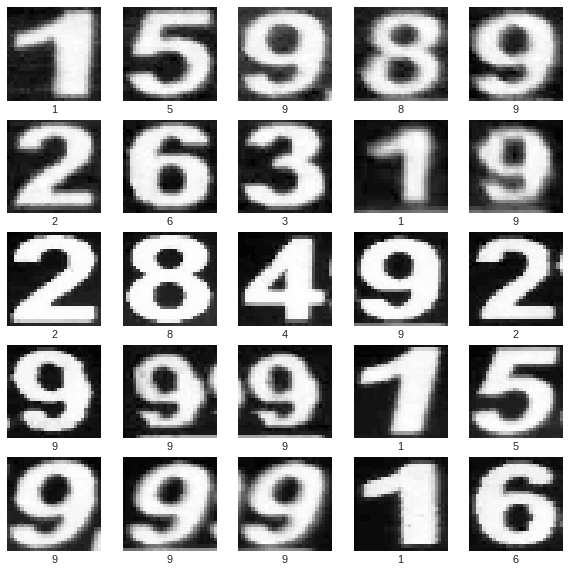

In [26]:
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image_datas[i])
  plt.xlabel(labels[i])

## Distribution of classes

In [0]:
(train_data,
 test_data,
 train_label,
 test_label) = train_test_split(image_datas, labels,test_size=0.2, random_state=34524)

In [28]:
print('Train sahpe: {}\nTest shape: {}\nTrain label: {}\nTest label: {}'.format(train_data.shape,
                                             test_data.shape,
                                             train_label.shape, 
                                             test_label.shape
                                                ))

Train sahpe: (1471, 28, 28)
Test shape: (368, 28, 28)
Train label: (1471,)
Test label: (368,)


Посмотрим на расспределения классов тренировочной и тестовой выборки

In [0]:
train_uniques, count_train_uniques = np.unique(train_label, return_counts=True)
test_uniques, count_test_uniques = np.unique(test_label, return_counts=True)

<BarContainer object of 10 artists>

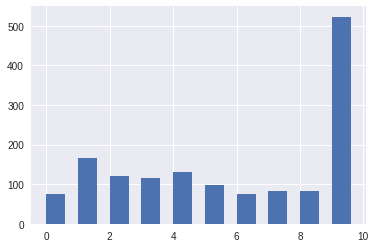

In [30]:
plt.bar(train_uniques, count_train_uniques, align='edge', width=0.6)

<BarContainer object of 10 artists>

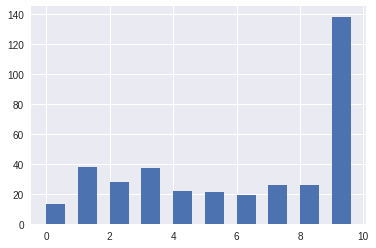

In [31]:
plt.bar(test_uniques, count_test_uniques,align='edge', width = 0.6)

## Deep learning

ANN

In [32]:
ann_model = Sequential(
    [
        Flatten(input_shape=(28, 28)),  
        
        Dense(100), 
        BatchNormalization(), 
        Activation('relu'),        
        Dense(50), 
        BatchNormalization(), 
        Activation('relu'),
        
        Dense(10, activation='softmax')
    ]
)

ann_model.compile(optimizer=Adam(lr=0.001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

W0825 14:20:48.061511 140217250256768 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
%%time
ann_model.fit(train_data, train_label, epochs=20,
                 validation_data=(test_data, test_label))

# test_loss, test_acc = ann_model.evaluate(test_data, test_label)
# print('\nTest accuracy:', test_acc, '\nTest loss:', test_loss, '\n')

Train on 1471 samples, validate on 368 samples
Epoch 1/20
1471/1471 [==============================] - 1s 647us/sample - loss: 0.6620 - acc: 0.8878 - val_loss: 1.0004 - val_acc: 0.7853
Epoch 2/20
1471/1471 [==============================] - 0s 112us/sample - loss: 0.1826 - acc: 0.9850 - val_loss: 0.8179 - val_acc: 0.9484
Epoch 3/20
1471/1471 [==============================] - 0s 153us/sample - loss: 0.1014 - acc: 0.9932 - val_loss: 0.5375 - val_acc: 0.9728
Epoch 4/20
1471/1471 [==============================] - 0s 104us/sample - loss: 0.0622 - acc: 0.9946 - val_loss: 0.2883 - val_acc: 0.9918
Epoch 5/20
1471/1471 [==============================] - 0s 208us/sample - loss: 0.0400 - acc: 0.9980 - val_loss: 0.2885 - val_acc: 0.9728
Epoch 6/20
1471/1471 [==============================] - 0s 211us/sample - loss: 0.0329 - acc: 0.9973 - val_loss: 0.1509 - val_acc: 0.9864
Epoch 7/20
1471/1471 [==============================] - 0s 167us/sample - loss: 0.0247 - acc: 0.9986 - val_loss: 0.1739 - val

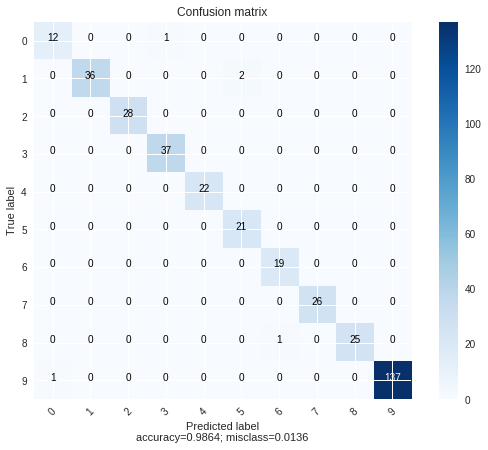

In [34]:
plot_confusion_matrix(confusion_matrix(test_label, ann_model.predict_classes(test_data)),
                      target_names=np.arange(10), normalize=False, 
                     )

CNN

In [0]:
cnn = Sequential()
cnn.add(Conv1D(200, kernel_size=3,activation='relu', input_shape=(28,28),padding='same'))
cnn.add(Conv1D(100,activation='relu', kernel_size=3))
BatchNormalization()
cnn.add(Flatten())
cnn.add(Dense(10, activation='softmax'))

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
cnn.fit(train_data, train_label, validation_data=(test_data, test_label), epochs=14, verbose=1)


Train on 1471 samples, validate on 368 samples
Epoch 1/14
1471/1471 [==============================] - 1s 695us/sample - loss: 0.7377 - acc: 0.7777 - val_loss: 0.0777 - val_acc: 0.9864
Epoch 2/14
1471/1471 [==============================] - 1s 577us/sample - loss: 0.0750 - acc: 0.9844 - val_loss: 0.0697 - val_acc: 0.9918
Epoch 3/14
1471/1471 [==============================] - 1s 580us/sample - loss: 0.0520 - acc: 0.9912 - val_loss: 0.0918 - val_acc: 0.9620
Epoch 4/14
1471/1471 [==============================] - 1s 617us/sample - loss: 0.0475 - acc: 0.9884 - val_loss: 0.0439 - val_acc: 0.9891
Epoch 5/14
1471/1471 [==============================] - 1s 581us/sample - loss: 0.0271 - acc: 0.9939 - val_loss: 0.0702 - val_acc: 0.9891
Epoch 6/14
1471/1471 [==============================] - 1s 585us/sample - loss: 0.0238 - acc: 0.9939 - val_loss: 0.0542 - val_acc: 0.9891
Epoch 7/14
1471/1471 [==============================] - 1s 583us/sample - loss: 0.0166 - acc: 0.9952 - val_loss: 0.0392 - val

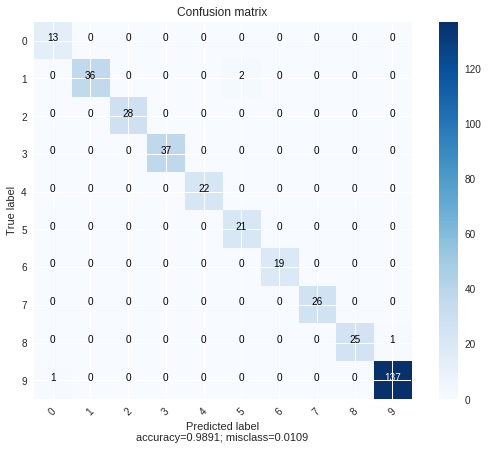

In [37]:
plot_confusion_matrix(confusion_matrix(test_label, cnn.predict_classes(test_data)),
                      target_names=np.arange(10), normalize=False, 
                     )

## Save models

In [38]:

#save models
cnn.save('cnn_model.h5')  # creates a HDF5 file 'my_model.h5'
ann_model.save('ann_model.h5')  # creates a HDF5 file 'my_model.h5'

#load_models
c = load_model('cnn_model.h5')
a = load_model('ann_model.h5')

W0825 14:21:48.760771 140217250256768 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0825 14:21:48.762656 140217250256768 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0825 14:21:49.663330 140217250256768 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

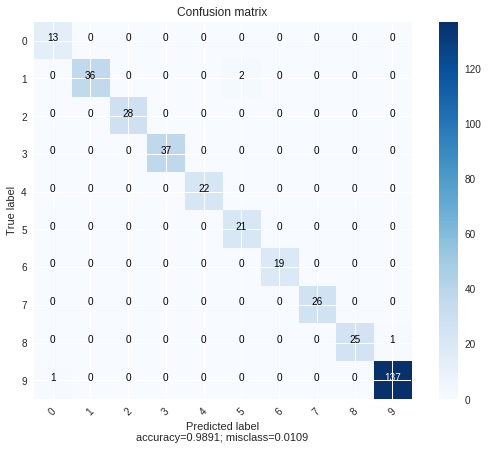

In [39]:
plot_confusion_matrix(confusion_matrix(test_label, c.predict_classes(test_data)),
                      target_names=np.arange(10), normalize=False, 
                     )